In [2]:
%pylab
%matplotlib inline

import sys
import numpy as np
import scipy.cluster.hierarchy as sch
import pylab
import scipy
import matplotlib.pyplot as plt

# Add the ptdraft folder path to the sys.path list
sys.path.append('../src/')

import data_config as config
import networkx as nx

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
/Users/akivalipshitz/Developer/neuronal-analysis/data/wbdata/
Reading


In [3]:
adjacency = nx.adjacency_matrix(config.connectome_networkx.data()).toarray()

Generating
Reading


/Library/Python/2.7/site-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [4]:
connectome = config.connectome_excel.data()

A = connectome['Connectome']['Origin']
B = connectome['Connectome']['Target']

alldata = np.concatenate((A,B))
nodes = np.unique(alldata)
class State():
  S = 1
  E = 2
  R = 3
  

neighbors = { }
state = { }
newstate = { }
for i in nodes:
  neighbors[i] = []
  state[i] = State.S
  newstate[i] = State.S


#drawing_colors = []

# Collects data for node_peers and node_index
#for c in xrange(0,len(nodes)):
#  graph.add_node(nodes[c])


for c in xrange(0, len(A)):
  neighbors[B[c]].append(A[c])



# let's get to work now
p=f=0.01

random.seed()
history = []
for step in xrange(0, 1000):
  for i in nodes:
    if (state[i] == State.S):
      if (random.random() < f):
        newstate[i] = State.E
      else: 
        for n in neighbors[i]:
          if state[n] == State.E:
            newstate[i] = State.E
    elif (state[i] == State.R):
      if (random.random() < p):
        newstate[i] = State.S
    elif (state[i] == State.E):
      newstate[i] = State.R
  for i in nodes:
    state[i] = newstate[i]

  history.append(newstate.values())



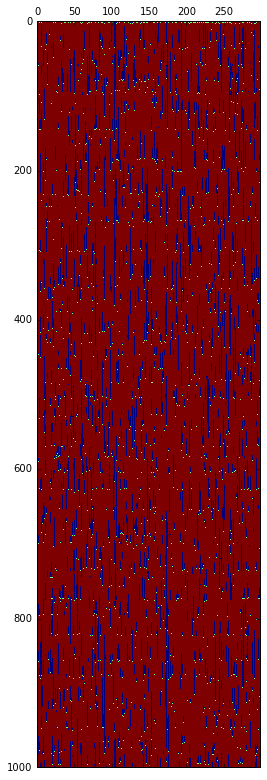

In [5]:
matshow(history)

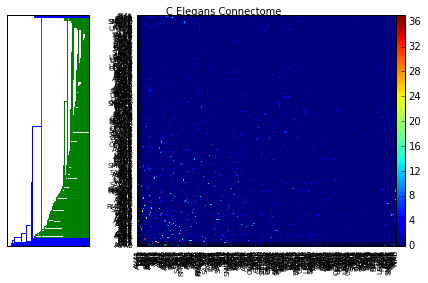

In [159]:
%matplotlib osx
import scipy.cluster.hierarchy as sch
from matplotlib.pyplot import *
connectome = config.connectome_networkx.data()
matg = adjacency
D= matg
# Compute and plot dendrogram.
fig = plt.figure()
fig.suptitle('C Elegans Connectome')

axdendro = fig.add_axes([0.00,0.15,0.19,0.8])
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right', labels = connectome.nodes())

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.15,0.6,0.8])
index = Z['leaves']
D = D[index][:,index]
im = axmatrix.matshow(D, aspect='auto', origin='lower')
axdendro.set_yticks([])
axdendro.set_xticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.9,0.15,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

ticks = np.array(connectome.nodes())[index]
xticks = np.arange(0,len(ticks))
yticks = np.arange(0,len(ticks))

axmatrix.set_yticks(yticks, minor=False)
axmatrix.set_yticklabels(ticks, minor=False,size='x-small')
axmatrix.yaxis.set_ticks_position('left') 



axmatrix.set_xticks(xticks, minor=False)
axmatrix.set_xticklabels(ticks, minor=False, rotation='vertical',size='x-small')
axmatrix.xaxis.set_ticks_position('bottom') 


In [6]:
weights = nx.adjacency_matrix(config.connectome_networkx.data()).toarray()

In [181]:
from enum import Enum

nodes = connectome

class NeuronState():
  S = 1
  E = 2
  R = 3

class TopologicalSimulator: 
    f = 0.001
    p = 0.001
    def __init__(self, graph):
        weights = nx.adjacency_matrix(graph).toarray()
        self.nodes = graph.nodes()
        self.nNodes = len(self.nodes)
        self.state = np.zeros(self.nNodes)
        self.state += NeuronState.S
        self.weights = weights
        self.newstate = np.array(self.state)
        
        self.neighbors = nx.to_dict_of_lists(graph)
        
#         self.state = { }
#         self.newstate = { }
#         for i in self.nodes:
#             self.state[i] = NeuronState.S
#             self.newstate[i] = NeuronState.S
#         print self.state
 
# Collects data for node_peers and node_index
#for c in xrange(0,len(nodes)):
#  graph.add_node(nodes[c])

    def step(self, f, p):

        S = self.state[self.state==NeuronState.S]
        probabilities = np.random.random_sample(size=S.shape[0])
        S[probabilities < f] = NeuronState.E
        self.newstate[self.state==NeuronState.S]=S
        
        isNeighbored = self.weights > 0
        stateRepeated = repeat(self.state, self.state.shape[0]).reshape(self.weights.shape).T
        stateNeighborThresholded = (stateRepeated * isNeighbored)
        neighborHasE = np.any(stateNeighborThresholded == NeuronState.E, axis=1)
        self.newstate[neighborHasE] = NeuronState.E
        
        R = self.state[self.state == NeuronState.R]
        probabilities = np.random.random_sample(size = R.shape[0])
        R[probabilities < p] = NeuronState.S
        self.newstate[self.state == NeuronState.R] = R
        
        self.newstate[self.state == NeuronState.E] =  NeuronState.R
        self.state[:]= self.newstate

    def run(self, iterations, f,p):
        history = np.empty((iterations, len(self.nodes)))
        np.random.seed()
        for i in xrange(iterations):
            self.step(f,p)
            history[i] = np.array(array(self.state))
            
        return history

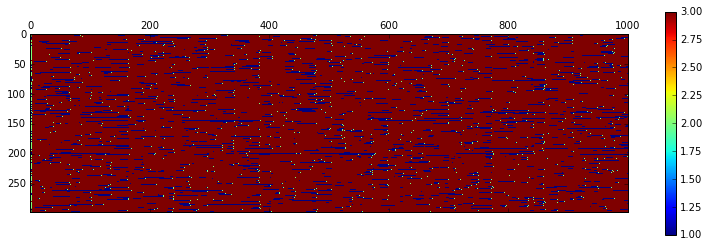

In [188]:
%matplotlib inline
sim = TopologicalSimulator(config.connectome_networkx.data())
results2 = sim.run(1000,0.01, 0.01)

matshow(results2.T)
colorbar()

savefig('/Users/akivalipshitz/Desktop/timeseries.jpg',dpi=400)




0.1 0.1
0.01 0.01
0.001 0.001
0.0001 0.0001
1e-05 1e-05
1e-06 1e-06


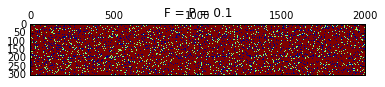

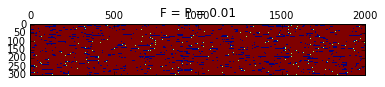

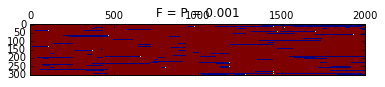

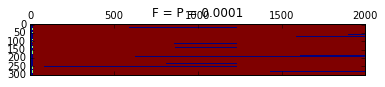

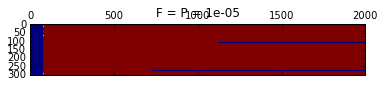

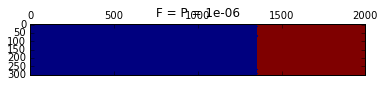

In [189]:
%matplotlib inline
# f,ax = subplots(5,1, figsize=(10*3, 20*5))
from itertools import product
for j, pos in enumerate(product(range(6), range(1))): 
    x,y = pos 
    f, ax = subplots(1,1)
    a = ax
    i = j+1
    sim = TopologicalSimulator(config.connectome_networkx.data())
    f = p = 10**(-i)
    print f,p
    results1 = sim.run(2000, f,p)
    a.matshow(results1.T)
    a.set_title('F = P = {0}'.format(f))
#     nodes = connectome.nodes()
#     a.set_yticks(arange(len(nodes)))
#     a.set_yticklabels(nodes,rotation='horizontal',size='3')
    savefig('/Users/akivalipshitz/Desktop/timeseries{0}.jpg'.format(j),dpi=400)

# matshow(results1)
# f.tight_layout()
